<a href="https://colab.research.google.com/github/Dr-Kitz28/Using-FeedForward-to-predict-Flight-Delay/blob/main/FeedForwardDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install tensorflow-addons --upgrade --no-deps

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
8691/8691 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.6930 - auc: 0.8177 - loss: 0.5503 - val_accuracy: 0.9648 - val_auc: 0.9865 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 2/50
8691/8691 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.8746 - auc: 0.9584 - loss: 0.2914 - val_accuracy: 0.7476 - val_auc: 0.9789 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 3/50
8685/8691 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8818 - auc: 0.9637 - loss: 0.2724
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8691/8691 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8818 - auc: 0.9637 - loss: 0.2724 - val_accuracy: 0.8916 - val_auc: 0.9653 - val_loss: 0.2380 - learning_rate: 0.0010


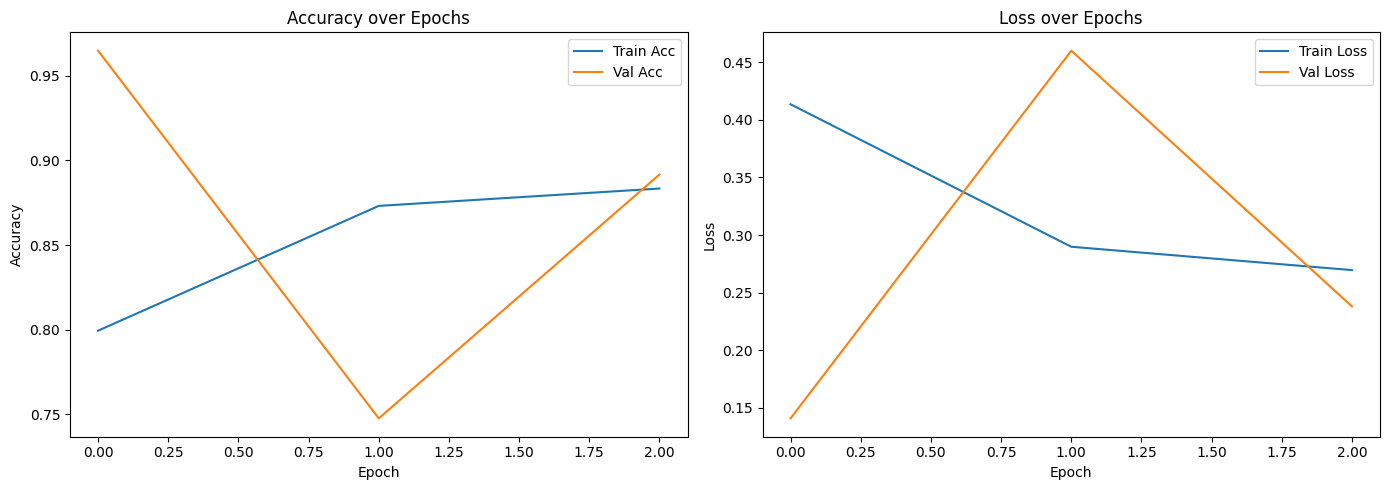

✅ Test Loss: 0.1413
✅ Test Accuracy: 0.9647
✅ Test AUC: 0.9858
✅ Model saved to 'processed_data/final_feedforward_model_adam.h5'
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Predictions saved to 'unseen_flights_100_adam_prediction.csv'


In [21]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

# STEP 1: Load & Preprocess Data
df = pd.read_csv("flights_clean.csv")
df.dropna(inplace=True)
df['Delayed'] = df['arr_delay'].apply(lambda x: 1 if x >= 15 else 0)

df['delay_per_flight'] = (
    df['carrier_delay'] + df['weather_delay'] + df['nas_delay'] +
    df['security_delay'] + df['late_aircraft_delay']
) / (df['arr_flights'] + 1e-5)
df['is_peak_month'] = df['month'].apply(lambda m: 1 if m in [6, 7, 12] else 0)

features = [
    'year', 'month', 'carrier', 'airport',
    'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct',
    'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
    'delay_per_flight', 'is_peak_month'
]
df = df[features + ['Delayed']]

# STEP 2: Encode & Scale
os.makedirs("processed_data", exist_ok=True)
categorical_cols = ['carrier', 'airport']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    joblib.dump(le, f"processed_data/le_{col}.pkl")

numeric_cols = [col for col in features if col not in categorical_cols]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
joblib.dump(scaler, "processed_data/scaler.pkl")

X = df[features].values
y = df['Delayed'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# STEP 3: Build Model with Adam + L2
class_weights = dict(zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.4),

    layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# STEP 4: Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# STEP 5: Plot Accuracy & Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# STEP 6: Evaluate & Save
results = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Loss: {results[0]:.4f}")
print(f"✅ Test Accuracy: {results[1]:.4f}")
print(f"✅ Test AUC: {results[2]:.4f}")
model.save("processed_data/final_feedforward_model_adam.h5")
print("✅ Model saved to 'processed_data/final_feedforward_model_adam.h5'")

# STEP 7: Predict 100 Synthetic Flights
import random

airlines = ['AA', 'DL', 'UA', 'WN', 'B6', 'AS']
airports = ['JFK', 'LAX', 'ORD', 'ATL', 'DFW', 'DEN']
unseen_data = pd.DataFrame([{
    "year": 2025,
    "month": random.randint(1, 12),
    "carrier": random.choice(airlines),
    "airport": random.choice(airports),
    "arr_flights": round(random.uniform(20, 100), 1),
    "carrier_ct": round(random.uniform(0.0, 5.0), 2),
    "weather_ct": round(random.uniform(0.0, 5.0), 2),
    "nas_ct": round(random.uniform(0.0, 5.0), 2),
    "security_ct": round(random.uniform(0.0, 1.0), 2),
    "late_aircraft_ct": round(random.uniform(0.0, 10.0), 2),
    "arr_cancelled": random.choice([0.0, 1.0]),
    "arr_diverted": random.choice([0.0, 1.0]),
    "carrier_delay": round(random.uniform(0.0, 300.0), 1),
    "weather_delay": round(random.uniform(0.0, 120.0), 1),
    "nas_delay": round(random.uniform(0.0, 180.0), 1),
    "security_delay": round(random.uniform(0.0, 30.0), 1),
    "late_aircraft_delay": round(random.uniform(0.0, 200.0), 1)
} for _ in range(100)])

unseen_data['delay_per_flight'] = (
    unseen_data['carrier_delay'] + unseen_data['weather_delay'] +
    unseen_data['nas_delay'] + unseen_data['security_delay'] +
    unseen_data['late_aircraft_delay']
) / (unseen_data['arr_flights'] + 1e-5)
unseen_data['is_peak_month'] = unseen_data['month'].apply(lambda m: 1 if m in [6, 7, 12] else 0)

le_carrier = joblib.load("processed_data/le_carrier.pkl")
le_airport = joblib.load("processed_data/le_airport.pkl")
scaler = joblib.load("processed_data/scaler.pkl")
unseen_data['carrier'] = le_carrier.transform(unseen_data['carrier'])
unseen_data['airport'] = le_airport.transform(unseen_data['airport'])
unseen_data[numeric_cols] = scaler.transform(unseen_data[numeric_cols])

X_unseen = unseen_data[features].values
unseen_data['delay_probability'] = model.predict(X_unseen).flatten()
unseen_data.to_csv("unseen_flights_100_adam_prediction.csv", index=False)
print("✅ Predictions saved to 'unseen_flights_100_adam_prediction.csv'")
